# Assignment 4

## Problem 1: Network Compression Using SVD

1. Train a fully-connected net for MNIST classification. It should be with 5 hidden layers each of which is with 1024 hidden units. Feel free to use whatever techniques you learned in class. You should be able to get the test accuracy above 98%. Let’s call this network “baseline”. You can reuse the one from the previous homework if its accuracy is good enough. Otherwise, this would be a good chance for you to improve your “baseline” MNIST classifier.

In [152]:
import numpy as np
import tensorflow as tf
import numpy as np
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imshow
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import History 

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Data load and preprocessing

In [11]:
# load the data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# reshaping the data
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

# normalizing the data
x_train=x_train/255.0
x_test=x_test/255.0

# converting labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

11501568/11490434 [==============================] - 0s 0us/step


#### Model Architechture

In [5]:

he_initializer=tf.keras.initializers.HeNormal()
model = Sequential()
model.add(Dense(1024, input_dim = 784, activation='relu', kernel_initializer=he_initializer))
model.add(Dense(1024, activation='relu', kernel_initializer=he_initializer))
model.add(Dense(1024, activation='relu', kernel_initializer=he_initializer))
model.add(Dense(1024, activation='relu', kernel_initializer=he_initializer))
model.add(Dense(1024, activation='relu', kernel_initializer=he_initializer))
model.add(Dense(10, activation='softmax', kernel_initializer=he_initializer))

#from keras.optimizers import Adam
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              803840    
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 10)                10250     
                                                                 
Total params: 5,012,490
Trainable params: 5,012,490
Non-

#### Fitting on train and predicting on test

In [11]:
# fit the keras model on the dataset
history = History()
model.fit(x_train, y_train, epochs=30, batch_size=512, validation_data=(x_test,y_test))

Epoch 1/30
118/118 [==============================] - 1s 7ms/step - loss: 0.0612 - accuracy: 0.8924 - val_loss: 0.0202 - val_accuracy: 0.9633
Epoch 2/30
118/118 [==============================] - 1s 6ms/step - loss: 0.0154 - accuracy: 0.9748 - val_loss: 0.0153 - val_accuracy: 0.9735
Epoch 3/30
118/118 [==============================] - 1s 6ms/step - loss: 0.0093 - accuracy: 0.9847 - val_loss: 0.0148 - val_accuracy: 0.9759
Epoch 4/30
118/118 [==============================] - 1s 6ms/step - loss: 0.0064 - accuracy: 0.9892 - val_loss: 0.0143 - val_accuracy: 0.9774
Epoch 5/30
118/118 [==============================] - 1s 6ms/step - loss: 0.0055 - accuracy: 0.9906 - val_loss: 0.0196 - val_accuracy: 0.9715
Epoch 6/30
118/118 [==============================] - 1s 6ms/step - loss: 0.0046 - accuracy: 0.9923 - val_loss: 0.0135 - val_accuracy: 0.9800
Epoch 7/30
118/118 [==============================] - 1s 6ms/step - loss: 0.0037 - accuracy: 0.9941 - val_loss: 0.0131 - val_accuracy: 0.9804
Epoch 

In [12]:
model.save_weights('/content/drive/MyDrive/Deep Learning Assignment/mnsit_weights',save_format='h5')

In [7]:
model.load_weights('/content/drive/MyDrive/Deep Learning Assignment/mnsit_weights',by_name=True)

#### Accuracy on the test data

In [14]:
# evaluate the keras model
_, accuracy = model.evaluate(x_test, y_test )
print('Accuracy on test data: %.2f' % (accuracy*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.0168 - accuracy: 0.9814
Accuracy on test data: 98.14


2. You learned that Singular Value Decomposition (SVD) can compress the weight matrices (Module
6). You have 6 different weight matrices in your baseline network, i.e. W (1) ∈ R784×1024, W (2) ∈ R1024×1024 , · · · , W (5) ∈ R1024×1024 , W (6) ∈ R1024×10 . Run SVD on each of them, except for W (6) which is too small already, to approximate the weight matrices: For this, feel free to use whatever implementation you can find. tf.svd or torch.svd will serve the purpose. Note that we don’t compress bias (just because we’re lazy).

3. If you look into the singular value matrix S(l), it should be a diagonal matrix. Its values are sorted in the order of their contribution to the approximation. What that means is that you can discard the least important singular values by sacrificing the approximation performance. For example, if you choose to use only D singular values and if the singular values are sorted in the descending order


### SVD on each layers of weights and then replacing the weight by the decomposition matrix

In [16]:
# Storing the weights
weights = []
bias = []
for i in range(6):
  weights.append(model.layers[i].get_weights()[0])
  bias.append(model.layers[i].get_weights()[1])

# initializing s,u,v
s,u,v =[[]], [[]],[[]]
for i in range(4):
  s.append([])
  u.append([])
  v.append([])

# SVD
def svd(mat):
  s, u, v = tf.linalg.svd(mat,full_matrices=False,compute_uv=True,name=None)
  return s, u, v

# doing svd for each weights
for i in range(5):
  s[i],u[i],v[i] = svd(weights[i])


# setting the weights in the model
def set_weights_layers(D, Full = False):
  for i in range(6):
    if i == 5:
      model.layers[i].set_weights((weights[i],bias[i]))
    elif Full == True and i == 0:
      W = tf.matmul(u[i][:,:784], tf.matmul(tf.linalg.diag(s[i][:784]), v[i][:,:784], adjoint_b=True))
      model.layers[i].set_weights((W,bias[i]))
    else:
      W = tf.matmul(u[i][:,:D], tf.matmul(tf.linalg.diag(s[i][:D]), v[i][:,:D], adjoint_b=True))
      model.layers[i].set_weights((W,bias[i]))


4. Vary your D from 10, 20, 50, 100, 200, to Dfull, where Dfull is the original size of S(l) (so D = Dfull means you use (1) instead of (2)). For example, Dfull = 784 when l = 1 and 1024 when l > 1. Now you have 6 differently compressed versions that are using W􏰄 for feedforward. Each 6 networks are
using one of the 6 D values of your choice. Report the test accuracy of the six approximated networks (perhaps a graph whose x-axis is D and y-axis is the test accuracy). You’ll see that when D = Dfull the test accuracy is almost as good as the baseline, while D = 10 will give you the worst performance. Note, however, that D = Dfull doesn’t give you any compression, while smaller choices of D can reduce the amount of computation during feedforward.



#### Varying D =10, 20, 50, 100, 200

#### D = 10

In [27]:
set_weights_layers(10)

# evaluate the keras model
_, accuracy_10 = model.evaluate(x_test, y_test )
print('Accuracy on the test data: %.2f' % (accuracy_10*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.3822 - accuracy: 0.6430
Accuracy on the test data: 64.30


#### D = 20

In [19]:
set_weights_layers(20)

# evaluate the keras model
_, accuracy_20 = model.evaluate(x_test, y_test )
print('Accuracy on the test data: %.2f' % (accuracy_20*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.0619 - accuracy: 0.9126
Accuracy on the test data: 91.26


#### D = 50

In [20]:
set_weights_layers(50)

# evaluate the keras model
_, accuracy_50 = model.evaluate(x_test, y_test )
print('Accuracy on the test data: %.2f' % (accuracy_50*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.0182 - accuracy: 0.9781
Accuracy: 97.81


#### D= 100

In [21]:
set_weights_layers(100)

# evaluate the keras model
_, accuracy_100 = model.evaluate(x_test, y_test )
print('Accuracy on the test data: %.2f' % (accuracy_100*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.0158 - accuracy: 0.9821
Accuracy: 98.21


#### D = 500

In [22]:
set_weights_layers(500)

# evaluate the keras model
_, accuracy_500 = model.evaluate(x_test, y_test )
print('Accuracy on the test data: %.2f' % (accuracy_500*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.0159 - accuracy: 0.9828
Accuracy on the test data: 98.28


#### D = Full

In [28]:
set_weights_layers(1024, Full= True)
_, accuracy_full = model.evaluate(x_test, y_test )
print('Accuracy on the test data: %.2f' % (accuracy_full*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.0159 - accuracy: 0.9828
Accuracy on the test data: 98.28


5. Report your test accuracies of the six SVDed versions along with your baseline performance. Report the number of parameters of your SVDed networks and compare them to the baseline’s. Be careful with the S(l) matrices: they are diagonal matrices, meaning that there are only D nonzero elements.

6. Note that you don’t have to run the SVD algorithm multiple times to vary D. Run it once, and extract different versions by varying D. That’s what’s good about SVD.

In [29]:
accuracy = [accuracy_10,accuracy_20,accuracy_50,accuracy_100,accuracy_500,accuracy_full]

In [31]:
D = ['10','20','50','100','500','Full']

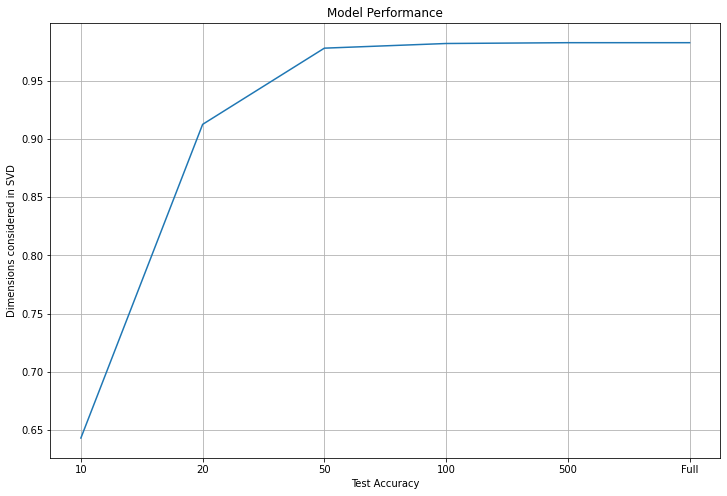

In [33]:

plt.figure(figsize=(12,8))
plt.plot(D, accuracy)
plt.xlabel('Test Accuracy')
plt.ylabel('Dimensions considered in SVD')
plt.title('Model Performance')

plt.grid()

##### Number of Parameters

$ Parameter = no. of \,input node * output\, nodes + bias\, nodes $ 

We can see the number of paramaters of each layer in model.summary. In total it uses 5012490 paramters

When we decompose the matrix into multiple D, we now only need to store D dimension to reconstruct the W back. 

D - 10
Params = $ 10*1024 + 10*1024 +10*1024 +10*1024 +10*1024 +10*1024 + 5*1024 (bias of five layers) = 66260$

D - 20
Params = $ 20*1024 + 20*1024 +20*1024 +20*1024 +20*1024 +10*1024 + 5*1024 = 117760$

D - 50
Params = $ 50*1024 + 50*1024 +50*1024 +50*1024 +50*1024 +10*1024  + 5*1024= 271360$

D - 100
Params = $ 100*1024 + 100*1024 +100*1024 +100*1024 +100*1024 +10*1024 + 5*1024= 527360$

D - 500
Params = $ 500*1024 + 500*1024 +500*1024 +500*1024 +500*1024 +10*1024 + 5*1024= 2575360$



In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1024)              803840    
                                                                 
 dense_7 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_8 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_9 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_10 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_11 (Dense)            (None, 10)                10250     
                                                                 
Total params: 5,012,490
Trainable params: 5,012,490
No

## Problem 2: Network Compression Using SVD 

1. Now you learned that the low rank approximation of W (l) gives you some compression. However, you might not like the performance of the too small D values. From now on, fix your D = 20 and let’s improve its performance.

2. Define a NEW network whose weight matrices W (l) are factorized. Again, this is a new one, different from your baseline in P1. In this new network, you don’t estimate W(l) directly anymore, but its
factor matrices, to reconstruct W(l) as follows: W(l) = U(l)V(l)⊤.

5. Again, note that U and V are the new variables that you need to estimate via optimization. They are fancier though, because they are initialized using the SVD results. If you stop here, you’ll get the same test performance as in P1.

6. Finetune this network. Now this new network has new parameters to update, i.e. U(l) and V(l) (as well as the bias terms). Update them using BP. Since you initialized the new parameters with SVD, which is a pretty good starting point, you may want to use a smaller-than-usual learning rate.
7. Report the test-time classification accuracy.


#### Extracting the weights from the baseline model

In [8]:
weights = []
bias = []
for i in range(6):
  weights.append(model.layers[i].get_weights()[0])
  bias.append(model.layers[i].get_weights()[1])

u_upd = [[0]]*5
v_upd = [[0]]*5

def u_v_svd(mat,D):
  s, u, v = tf.linalg.svd(mat,full_matrices=False,compute_uv=True,name=None)
  u = u[:,:D]
  vh = tf.matmul(tf.linalg.diag(s[:D]), v[:,:D], adjoint_b=True)
  return u,vh

for i in range(5):
  u_upd[i],v_upd[i] = u_v_svd(weights[i], 20)

#### Model Architechture 
Now this model has 10 layers. Each layers in initialized by decomposition matrix u, v

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
model = Sequential()
model.add(Dense(20, input_dim = 784,activation=None,name='layer_v1'))
model.add(Dense(1024, input_dim = 20,activation='relu',name='layer_u1'))
model.add(Dense(20, input_dim = 1024,activation=None,name='layer_v2'))
model.add(Dense(1024, input_dim = 20,activation='relu',name='layer_u2'))
model.add(Dense(20, input_dim = 1024,activation=None,name='layer_v3'))
model.add(Dense(1024, input_dim = 20,activation='relu',name='layer_u3'))
model.add(Dense(20, input_dim = 1024,activation=None,name='layer_v4'))
model.add(Dense(1024, input_dim = 20,activation='relu',name='layer_u4'))
model.add(Dense(20, input_dim = 1024,activation=None,name='layer_v5'))
model.add(Dense(1024, input_dim =20 ,activation='relu',name='layer_u5'))
model.add(Dense(10, input_dim =1024 ,activation='softmax',name='layer_op'))

In [ ]:
model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_v1 (Dense)            (None, 20)                15700     
                                                                 
 layer_u1 (Dense)            (None, 1024)              21504     
                                                                 
 layer_v2 (Dense)            (None, 20)                20500     
                                                                 
 layer_u2 (Dense)            (None, 1024)              21504     
                                                                 
 layer_v3 (Dense)            (None, 20)                20500     
                                                                 
 layer_u3 (Dense)            (None, 1024)              21504     
                                                                 
 layer_v4 (Dense)            (None, 20)               

##### Initializing the weights by u and v

In [ ]:
m = 0
n = 0
for i in range(10):
  if i%2==0:
    model.layers[i].set_weights((u_upd[m], bias[m][:20]))
    m+=1
  else:
    model.layers[i].set_weights((v_upd[n],bias[n]))
    n+=1

In [ ]:
model.fit(x_train,y_train,epochs=20)

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5186 - accuracy: 0.8256
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1946 - accuracy: 0.9409
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1437 - accuracy: 0.9555
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1165 - accuracy: 0.9644
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0999 - accuracy: 0.9693
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0852 - accuracy: 0.9735
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0740 - accuracy: 0.9765
Epoch 8/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0656 - accuracy: 0.9793
Epoch 9/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0581 - accuracy: 0.9820
Epoch 10/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.053

#### Accuracy in the test data

In [ ]:
# evaluate the keras model
_, accuracy = model.evaluate(x_test, y_test )
print('Accuracy: %.2f' % (accuracy*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.1291 - accuracy: 0.9734
Accuracy: 97.34


We compressed the model parameters to 4% of the orginal size without effecting the accuracy much



## Problem 3: Network Compression Using SVD 

1. Another way to improve our D = 20 case is to inform the training process of the SVD approximation. It’s a different method from P1, where SVD was performend once after the network training was completed. This time, we do SVD at every epoch.

2. Initialize W (l) using the “baseline” model. We will finetune it.

3. This time, for the feedforward pass, you never use W(l). Instead, you do SVD at every iteration and
make sure the feedforward pass always uses W(l) = U(l) S(l) V (l)⊤ .
􏰄 :,1:20 1:20,1:20 :,1:20

4. What that means for the training algorithm is that you should think of the low-rank SVD procedure as an approximation function W(l) ≈ f(W(l)) = U(l) S(l) V (l)⊤ .

##### Storing the weights

In [24]:
weights = []
bias = []
for i in range(6):
  weights.append(model.layers[i].get_weights()[0])
  bias.append(model.layers[i].get_weights()[1])

##### Custom gradient

In [34]:
@tf.custom_gradient
def weights_custom(weight):
    s,u,v = tf.linalg.svd(weights,compute_uv=True,full_matrices=True)
    W_hat=tf.matmul(u[:,:20], tf.matmul(tf.linalg.diag(s[:20]), v[:,:20], adjoint_b=True))

    def grad(dy):
        return tf.gradients(dy, W_hat)
    return W_hat, grad



##### Custom Layers

In [35]:
class custom_layer(keras.layers.Layer): #dense

     def __init__(self,units,layer_num,input_shape):
      super(custom_layer, self).__init__()
      self.units=units
      self.layer_num = layer_num
      self.w=tf.Variable(
            initial_value=weights[self.layer_num],
            trainable=True,
        )
      self.b=tf.Variable(
            initial_value=bias[self.layer_num],
            trainable=True,
        )
      
      def call(self, x):
          W_hat=weights_custom(self.w)  
          a=keras.activations.relu(tf.matmul(x,W_hat)+self.b)
          return a

##### Model Architechture

In [36]:
model = Sequential()
model.add(custom_layer(units=1024,input_shape=(784,),layer_num=0))
model.add(custom_layer(units=1024,layer_num=1,input_shape=(1024,)))
model.add(custom_layer(units=1024,layer_num=2,input_shape=(1024,)))
model.add(custom_layer(units=1024,layer_num=3,input_shape=(1024,)))
model.add(custom_layer(units=1024,layer_num=4,input_shape=(1024,)))
model.add(Dense(units=10,activation='softmax'))

In [40]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']);

In [16]:
model_hist=model.fit(x=x_train,y=y_train,batch_size=1024,epochs=20,shuffle=True,verbose=2,validation_data=(x_test,y_test)) #(x_train,y_train),(x_test,y_test)

Epoch 1/20
59/59 - 0s - loss: 0.0826 - accuracy: 0.8965 - val_loss: 0.0798 - val_accuracy: 0.9030 - 289ms/epoch - 5ms/step
Epoch 2/20
59/59 - 0s - loss: 0.0817 - accuracy: 0.8977 - val_loss: 0.0788 - val_accuracy: 0.9036 - 233ms/epoch - 4ms/step
Epoch 3/20
59/59 - 0s - loss: 0.0808 - accuracy: 0.8989 - val_loss: 0.0781 - val_accuracy: 0.9037 - 229ms/epoch - 4ms/step
Epoch 4/20
59/59 - 0s - loss: 0.0800 - accuracy: 0.9002 - val_loss: 0.0774 - val_accuracy: 0.9052 - 238ms/epoch - 4ms/step
Epoch 5/20
59/59 - 0s - loss: 0.0793 - accuracy: 0.9007 - val_loss: 0.0766 - val_accuracy: 0.9054 - 235ms/epoch - 4ms/step
Epoch 6/20
59/59 - 0s - loss: 0.0786 - accuracy: 0.9018 - val_loss: 0.0760 - val_accuracy: 0.9059 - 220ms/epoch - 4ms/step
Epoch 7/20
59/59 - 0s - loss: 0.0780 - accuracy: 0.9029 - val_loss: 0.0754 - val_accuracy: 0.9070 - 244ms/epoch - 4ms/step
Epoch 8/20
59/59 - 0s - loss: 0.0774 - accuracy: 0.9031 - val_loss: 0.0749 - val_accuracy: 0.9072 - 241ms/epoch - 4ms/step
Epoch 9/20
59/59

#### Accuracy in the test data

In [17]:
_, accuracy = model.evaluate(x_test, y_test )
print('Accuracy on the test data: %.2f' % (accuracy*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.0706 - accuracy: 0.9116
Accuracy on the test data: 91.16


## Problem 4: Speaker Verification

1. In this problem, we are going to build a speaker verification system. It takes two utterances as input, and predicts whether they were spoken by the same speaker (positive class) or not (negative class).


2. trs.pkl contains an 500×16,180 matrix, whose row is a speech signal with 16,180 samples. They are the returned vectors from the librosa.load function. Similarly, tes.pkl holds a 200×22,631 matrix.


3. The training matrix is ordered by speakers. Each speaker has 10 utterances, and there are 50 such speakers (that’s why there are 500 rows). Similarly, the test set has 20 speakers, each of which is with 10 utterances.


4. Randomly sample L pairs of utterances from the ten utterance of the first speaker. In theory, there are 􏰀10􏰁 = 45 pairs you can sample from (the order of the two utterances within a pair doesn’t matter).
You can use all 45 of them if you want. These are the positive examples in your first minibatch.


5. Let’s construct L negative pairs as well. First, randomly sample L utterances from the 49 training speakers. Second, randomly sample another L utterances from the first speaker (the speaker you sampled the positive pairs from). Using these two sets, each has L examples, form another set of L pairs. If L > 10, you’ll need to repeatedly use the first speaker’s utterance (i.e. sampling with replacement). This set is your negative examples, each of whose pair contains an utterance from the first speaker and a random utterance spoken by a different speaker.

6. The L positive pairs and L negative pairs form your first minibatch. You have 2L pairs of utterances in total.

7. Repeat this process for the other training speakers, so that each speaker is represented by L positive pairs and L negative pairs. By doing so, you can form 50 minibatches with a balanced number of positive and negative pairs.

8. Train a Siamese network that tries to predict 1 for the positive pairs and 0 for the negative ones. In a minibatch, since you have L positive and L negative pairs, respectively, your net must predict L ones and L zeros, respectively.

9. I found that STFT on the signals serves the initial feature extraction process. Therefore, your Siamese network will take as input TWO spectrograms, each of which is of size 513 × T . I wouldn’t care too much about your choice of the network architecture this time (if it works anyway), but it has to somehow predict a fixed-length feature vector for the given sequence of spectra (consequently, TWO fixted-length vectors for the pair of input spectrograms). Using the inner product of the two latent embedding vectors as the input to the sigmoid function, you’ll do a logistic regression. Use your imagination and employ whatever techniques you learned in class to design/train this network.

10. Construct similar batches from the test set, and test the verification accuracy of your network. Report your test-time speaker verification performance. I was able to get a decent result (∼ 70%) with a reasonable network architecture (e.g., a GRU working on STFT), which converged in a reasonable amount of time (i.e. in an hour).

11. Submit your code and accuracy on the test examples.


In [156]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout,LSTM, GRU
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
import librosa
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

#### Loading the data

In [153]:
with open('/content/drive/MyDrive/Deep Learning Assignment/hw4_trs.pkl','rb') as file:
  train_data=pickle.load(file)

with open('/content/drive/MyDrive/Deep Learning Assignment/hw4_tes.pkl','rb') as file:
  test_data=pickle.load(file)

#### Spectogram

In [158]:
train_spect_mag=[]
for i in range(len(train_data)):
  train_spect_mag.append(np.abs(librosa.stft(train_data[i], n_fft=1024, hop_length=512)))

test_spect_mag=[]
for i in range(len(test_data)):
  test_spect_mag.append(np.abs(librosa.stft(test_data[i], n_fft=1024, hop_length=512)))

train_data=np.array(train_spect_mag)
test_data=np.array(test_spect_mag)

In [159]:
train_data.shape,test_data.shape

((500, 513, 32), (200, 513, 45))

#### Data Preprocessing

In [162]:
def data_preprocessing(data):
  input_1=[]
  input_2=[]
  labels=[]


  for i in range(0,len(data),10):
    sample1=[i for i in range(i,i+10)]
    sample2=[i for i in range(0,i)]+[i for i in range(i+10,len(data))]
    index1=np.random.choice(sample1,size=45,replace=True)
    index2=np.random.choice(sample1,size=45,replace=True)
    index3=np.random.choice(sample1,size=45,replace=True)
    index4=np.random.choice(sample2,size=45,replace=False)

    x1_pos = data[index1]
    x2_pos = data[index2]

    x1_neg = data[index3]
    x2_neg = data[index4]
    if len(input_1)!=0 and len(input_2)!=0 and len(labels)!=0:
      input_1=np.concatenate((input_1,x1_pos,x1_neg))
      input_2=np.concatenate((input_2,x2_pos,x2_neg))

      labels=np.concatenate((labels,np.ones((45,1)),np.zeros((45,1))))  
    else:
      input_1=np.concatenate((x1_pos,x1_neg))
      input_2=np.concatenate((x2_pos,x2_neg))

      labels=np.concatenate((np.ones((45,1)),np.zeros((45,1))))    
  return input_1,input_2,labels  


train_mat_1,train_mat_2,train_labels=data_preprocessing(train_data)
test_mat_1,test_mat_2,test_labels=data_preprocessing(test_data)

#### Model Building

In [178]:
def siamese_helper_fun(inputShape, embeddingDim=48):
  inputs = Input(inputShape)
  #x = LSTM(activation='relu',units=128,return_sequences=False,name='layer_1')(inputs)
  x = GRU(activation='tanh',units=128,return_sequences=False,name='layer_1')(inputs)
  outputs = Dense(units=embeddingDim,activation='relu',kernel_initializer='HeNormal')(x)
  model = Model(inputs, outputs)
  return model

In [179]:
Input_A = Input((None,513))
Input_B = Input((None,513))

embeddingsExtractor = siamese_helper_fun((None,513))

embedding_A = embeddingsExtractor(Input_A)
embedding_B = embeddingsExtractor(Input_B)

distance=tf.expand_dims(tf.reduce_sum(tf.multiply(embedding_A, embedding_B),axis=1),axis=-1)

In [180]:
outputs = Dense(1, activation="sigmoid",kernel_initializer='GlorotNormal')(distance)
model = Model(inputs=[Input_A, Input_B], outputs=outputs)

In [181]:
model.compile(loss="binary_crossentropy", optimizer=Adam(),
	metrics=["accuracy"])

In [167]:
train_mat_1=np.transpose(train_mat_1,axes=(0,2,1))
train_mat_2=np.transpose(train_mat_2,axes=(0,2,1))
test_mat_1=np.transpose(test_mat_1,axes=(0,2,1))
test_mat_2=np.transpose(test_mat_2,axes=(0,2,1))

In [117]:
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, None, 513)]  0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, None, 513)]  0           []                               
                                                                                                  
 model_15 (Functional)          (None, 48)           189348      ['input_25[0][0]',               
                                                                  'input_26[0][0]']               
                                                                                                  
 tf.math.multiply_8 (TFOpLambda  (None, 48)          0           ['model_15[0][0]',        

In [168]:
model.fit([train_mat_1, train_mat_2], train_labels,validation_data=([test_mat_1,test_mat_2], test_labels),batch_size=128, epochs=15)

Epoch 1/15
36/36 [==============================] - 5s 95ms/step - loss: 0.8242 - accuracy: 0.5311 - val_loss: 0.6898 - val_accuracy: 0.5311
Epoch 2/15
36/36 [==============================] - 3s 80ms/step - loss: 0.6778 - accuracy: 0.5611 - val_loss: 0.6847 - val_accuracy: 0.5511
Epoch 3/15
36/36 [==============================] - 3s 81ms/step - loss: 0.6782 - accuracy: 0.5718 - val_loss: 0.6886 - val_accuracy: 0.5433
Epoch 4/15
36/36 [==============================] - 3s 78ms/step - loss: 0.6720 - accuracy: 0.5718 - val_loss: 0.6863 - val_accuracy: 0.5394
Epoch 5/15
36/36 [==============================] - 3s 81ms/step - loss: 0.6597 - accuracy: 0.5871 - val_loss: 0.6799 - val_accuracy: 0.5739
Epoch 6/15
36/36 [==============================] - 3s 80ms/step - loss: 0.6408 - accuracy: 0.6240 - val_loss: 0.6690 - val_accuracy: 0.5861
Epoch 7/15
36/36 [==============================] - 3s 80ms/step - loss: 0.6448 - accuracy: 0.6129 - val_loss: 0.6789 - val_accuracy: 0.5678
Epoch 8/15
36

In [170]:
test_acc=(sum((model.predict([test_mat_1,test_mat_2])>=0.5)==test_labels)/len(test_labels))[0]*100

In [171]:
print(f'Final Test Accuracy {round(test_acc,2)}')

Final Test Accuracy 64.39


In [172]:
model.save_weights('/content/drive/MyDrive/Deep Learning Assignment/siamese',save_format='h5')